# Inversión

## Instalación

In [1]:
!pip install adversarial-robustness-toolbox==1.4.1

     |████████████████████████████████| 768kB 2.7MB/s 
     |████████████████████████████████| 235kB 12.8MB/s 
     |████████████████████████████████| 21.0MB 1.4MB/s 
     |████████████████████████████████| 7.1MB 34.1MB/s 
     |████████████████████████████████| 747kB 39.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt
from art.utils import load_mnist

In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

## Cargar datos

In [5]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [6]:
print("x_train shape:", x_train.shape)
print("y_train shape:", x_train.shape)
print("x_test shape:", x_train.shape)
print("y_test shape:", x_train.shape)

print("min_pixel_value:", min_pixel_value)
print("min_pixel_value:", max_pixel_value)

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 28, 28, 1)
x_test shape: (60000, 28, 28, 1)
y_test shape: (60000, 28, 28, 1)
min_pixel_value: 0.0
min_pixel_value: 1.0


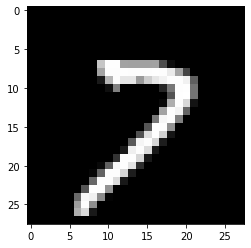

In [7]:
sample = 567
plt.imshow(x_train[sample].reshape((28, 28)), cmap='gray', interpolation='none')

## Entrenar modelo

In [8]:
from art.estimators.classification import KerasClassifier

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

classifier.fit(x_train, y_train, batch_size=128, nb_epochs=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
468/468 [==============================] - 5s 10ms/step - batch: 233.5000 - size: 128.0000 - loss: 0.2222 - accuracy: 0.9333
Epoch 2/10
468/468 [==============================] - 4s 10ms/step - batch: 233.5000 - size: 128.0000 - loss: 0.0636 - accuracy: 0.9804
Epoch 3/10
468/468 [==============================] - 4s 9ms/step - batch: 233.5000 - size: 128.0000 - loss: 0.0454 - accuracy: 0.9864
Epoch 4/10
468/468 [==============================] - 4s 10ms/step - batch: 233.5000 - size: 128.0000 - loss: 0.0368 - accuracy: 0.9887
Epoch 5/10
468/468 [==============================] - 4s 9ms/step - batch: 233.5000 - size: 128.0000 - loss: 0.0281 - accuracy: 0.9916
Epoch 6/10
468/468 [==============================] - 4s 9ms/step - batch: 233.5000 - size: 128.0000 - loss: 0.0250 - accuracy: 0.9920
Epoch 7/10
468/468 [==============================] - 4s 9ms/step - batch: 233.5000 - size: 128.0000 - loss: 0.

In [10]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {}%".format(accuracy * 100))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Accuracy on test examples: 99.18%


# Ataque de inversión

In [11]:
from art.attacks.inference.model_inversion import MIFace

In [12]:
y = np.arange(10)

In [13]:
attack = MIFace(classifier, max_iter=10000, threshold=0.99)

In [14]:
x_init_white = np.zeros((10, 28, 28, 1))
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
x_init_black = np.ones((10, 28, 28, 1))
x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)

x_inits = [x_init_white, x_init_grey, x_init_black, x_init_random, x_init_average]
x_inits_names = ["white", "grey", "black", "random", "average"]

In [15]:
x_infers = []
for x in x_inits:
  x_infers.append(attack.infer(x, y))

Model inversion: 100%|██████████| 10/10 [06:55<00:00, 41.59s/it]


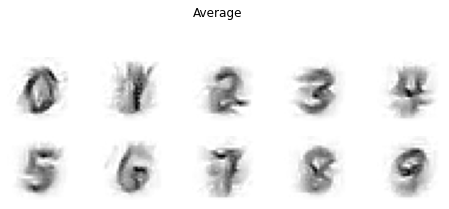

In [17]:
plt.figure(figsize=(8,7))
plt.suptitle("Average")
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_infers[4][i].reshape((28, 28)), cmap='gray_r') # Average
    plt.axis("off")

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

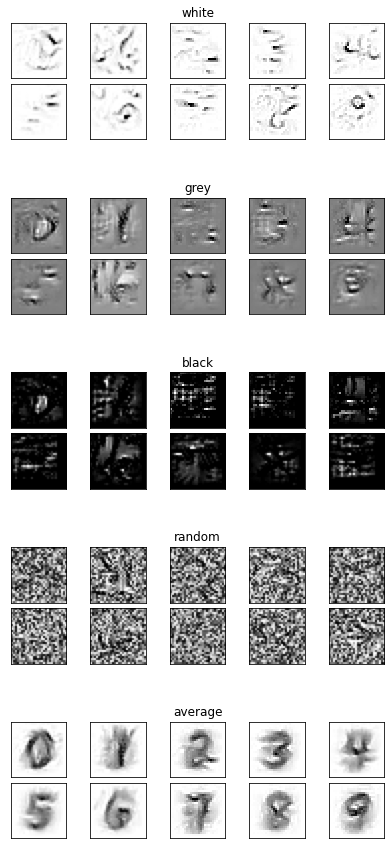

In [19]:
fig = plt.figure(figsize=(7, 15))
outer = gridspec.GridSpec(5, 1, hspace=0.5)

for i, x_infer in enumerate(x_infers):
    inner = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(10):
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(x_infers[i][j].reshape((28, 28)), cmap='gray_r')
        
        if j == 2:
          ax.set_title(x_inits_names[i])
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

fig.show()

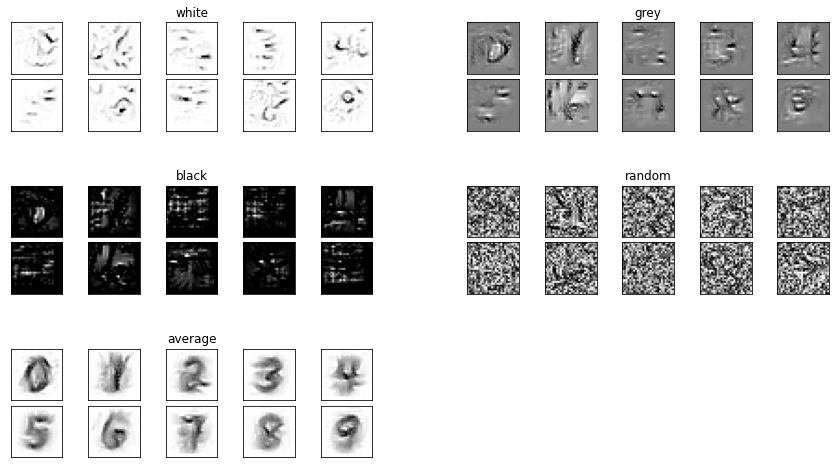

In [20]:
fig = plt.figure(figsize=(15, 8))
outer = gridspec.GridSpec(3, 2, hspace=0.5)

for i, x_infer in enumerate(x_infers):
    inner = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(10):
        
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(x_infers[i][j].reshape((28, 28)), cmap='gray_r')
        
        if j == 2:
          ax.set_title(x_inits_names[i])
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

fig.show()